In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import time

In [2]:
!pip3 install Pillow

In [3]:
!uv pip install -q --system numba-cuda==0.4.0

In [4]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0

In [5]:
from numba import cuda
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mping

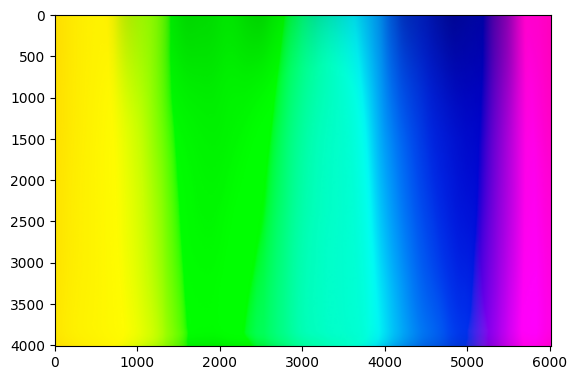

In [6]:
image = mping.imread("/content/drive/MyDrive/rgb.jpg")
plt.imshow(image)

In [7]:
image.shape

(4016, 6016, 3)

In [8]:
imageH = image.shape[0]
imageW = image.shape[1]
imageDim = image.shape[2]

In [33]:
pixelcnt = imageH * imageW
blockSize = 200
gridSize = pixelcnt // blockSize

In [10]:
img = image.reshape(pixelcnt,imageDim)

In [11]:
img.shape

(24160256, 3)

In [12]:
d_host = cuda.to_device(img)

In [13]:
d_image = cuda.device_array_like(img)

In [14]:
@cuda.jit
def grayscale(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

In [36]:
elapses = []
blocksizes = []

In [37]:
for blocks in range (1,blockSize + 1):
  blocksizes.append(blocks)
  start = time.time()
  grayscale[gridSize,blocks](d_host,d_image)
  elapsed = time.time() - start
  elapses.append(elapsed)

In [16]:
result = d_image.copy_to_host()

In [17]:
result.shape

(24160256, 3)

In [18]:
res_img = result.reshape(imageH,imageW,imageDim)

In [19]:
res_img.shape

(4016, 6016, 3)

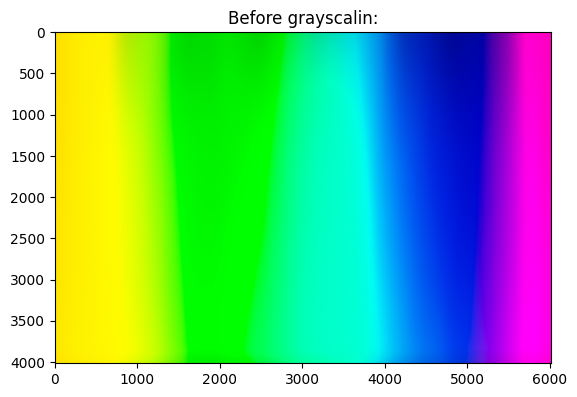

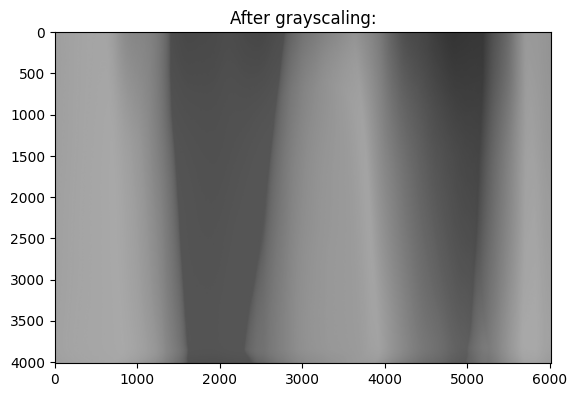

In [31]:
plt.figure()
plt.imshow(image)
plt.title("Before grayscalin:")
plt.figure()
plt.imshow(res_img)
plt.title("After grayscaling:")
plt.show()

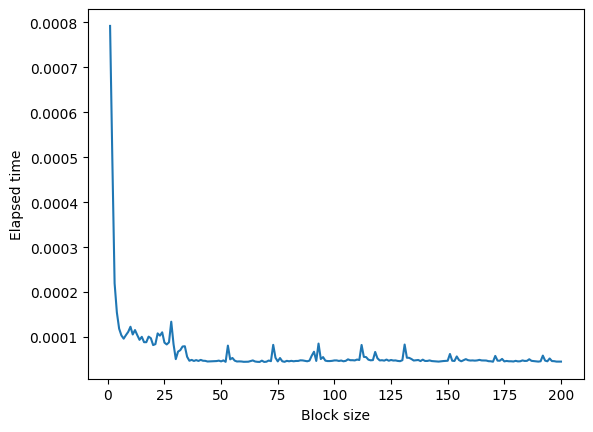

In [38]:
plt.plot(blocksizes,elapses)
plt.xlabel("Block size")
plt.ylabel("Elapsed time")
plt.show()